# Deep Learning course - LAB 10

## Generative Adversarial Networks

Generative Adversarial Networks (GANs) are a neural-based category of generative models.

Up to now, we have seen only **discriminating models**, i.e. models tasked with learning $P(Y\vert X)$, where $X$ are the observations and $Y$ is the dependent variable (category or scalars, depending uon the task).

**Generative models**, on the other hand, are tasked with learning $P(Y, X)$, i.e. in simple terms they learn a _**rule**_ through which we can sample (generate) any amount of data.

Specifically, GANs are expressed as a game in which two models are in competition:
* a **generator** $G$ generates synthetic data
* a **discriminator** $D$ distinguishes whether a piece of data is synthetic or not

$D$ is usually expressed as a *simple* network for binary classification and trained using the binary cross-entropy loss. Given $D(x)\in[0,1]$ output of the discriminator and $y\in\{0,1\}$ the ground truth, $\mathcal{L}_D(x) = -y\log(D(x)) - (1-y) \log(1-D(x))$.

On the other hand, $G$ is a more complex entity. The input is a *latent variable* $z$, while the output is a point in the data space $\mathcal{D}$ (i.e. $x\in\mathcal{D}$). The generator, recall, is tasked with producing samples which $D$ misclassifies as real. We may then ask for the following: $G^\star = \text{argmax}_G \{ \mathcal{L}_D(G(z)) \}$, or, that the generated data $G(z)$ *increase* the loss of $D$. Actually, to 

Merging the two concepts, we express the GAN in terms of a *minmax* game:

$\min_G \max_D \log(D(x)) + \log(1-D(x))$ (note: the signs are switched w.r.t. $\mathcal{L}_D$, so the $\min$ becomes $\max$ and vice-versa).



In [129]:
import torch
from torch import nn
from scripts.mnist import get_data
from matplotlib import pyplot as plt
import numpy as np

In [2]:
trainloader, testloader, _, _ = get_data()

In [112]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

this is a free reinterpretation of DCGAN [1](https://arxiv.org/abs/1511.06434) build s.t. we can match the original shape of MNIST. We need to tweak the values of the transposed convolution because the original implementation is thought for images with $n^2$ spatial dimensions, while MNIST does not abide to that prerequisite.

In [96]:
a = torch.rand((1,100,1,1))
base_width = 64
a = nn.ConvTranspose2d(dim_latent, base_width*8, kernel_size=5, bias=False)(a)
print(a.shape)
a = nn.ConvTranspose2d(base_width*8, base_width*4, kernel_size=5, bias=False)(a)
print(a.shape)
a = nn.ConvTranspose2d(base_width*4, base_width*2, kernel_size=5, stride=2, bias=False)(a)
print(a.shape)
a = nn.ConvTranspose2d(base_width*2, base_width*1, kernel_size=5, bias=False)(a)
print(a.shape)
a = nn.ConvTranspose2d(base_width, 1, kernel_size=4, bias=False)(a)
print(a.shape)

torch.Size([1, 512, 5, 5])
torch.Size([1, 256, 9, 9])
torch.Size([1, 128, 21, 21])
torch.Size([1, 64, 25, 25])
torch.Size([1, 1, 28, 28])


In [139]:
class Generator(nn.Module):
    def __init__(self, dim_latent, base_width=64, output_ch=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(dim_latent, base_width*8, kernel_size=5, bias=False),
            nn.BatchNorm2d(base_width*8),
            nn.ReLU(),
            nn.ConvTranspose2d(base_width*8, base_width*4, kernel_size=5, bias=False),
            nn.BatchNorm2d(base_width*4),
            nn.ReLU(),
            nn.ConvTranspose2d(base_width*4, base_width*2, kernel_size=5, stride=2, bias=False),
            nn.BatchNorm2d(base_width*2),
            nn.ReLU(),
            nn.ConvTranspose2d(base_width*2, base_width, kernel_size=5, bias=False),
            nn.BatchNorm2d(base_width),
            nn.ReLU(),
            nn.ConvTranspose2d(base_width, output_ch, kernel_size=4, bias=False),
            nn.Tanh() #tanh so the output is in 0-1
        )
    
    def forward(self, z):
        z = z.unsqueeze(-1).unsqueeze(-1) # append two spatial dimensions to make it image-like
        return self.layers(z)

Let's test if the generator produces an output of the desired shape:

In [140]:
dim_latent = 100
g = Generator(dim_latent=dim_latent)
g.apply(weights_init)
g(torch.rand((1,dim_latent))).shape

torch.Size([1, 1, 28, 28])

In [141]:
class Discriminator(nn.Module):
    def __init__(self, base_width=64, input_ch=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(input_ch, base_width, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(base_width, base_width*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_width*2),
            nn.LeakyReLU(),
            nn.Conv2d(base_width*2, base_width*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_width*4),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(base_width*4, 1),
            nn.Sigmoid() # squeeze output in the 0-1 axis so we can apply the loss
        )
    
    def forward(self, X):
        return self.layers(X).flatten()

Check if shape is correct: given batch of size $B$, we expect to have a tensor of shape `[B]` as output

In [142]:
d = Discriminator()
d.apply(weights_init)
d(torch.rand(10,1,28,28)).shape


torch.Size([10])

In [143]:
loss_fn = nn.BCELoss() # binary cross entropy

device = "cuda:0"

real_label = 1
fake_label = 0



# for the discriminator
sigma_noise = .5

lr = 2e-4
beta1 = 0.5
beta2 = 0.999

# 2 Adams with same hyperparameters
optim_d = torch.optim.Adam(d.parameters(), lr=lr, betas=(beta1, beta2))
optim_g = torch.optim.Adam(g.parameters(), lr=lr, betas=(beta1, beta2))


In [144]:
ite_print = 25
num_epochs = 3

d = d.to(device)
g = g.to(device)

In [145]:
n_fake = 24
fixed_noise = torch.randn([n_fake, dim_latent]).to(device)
fakeimgs = np.empty([num_epochs, n_fake, 28, 28])

def tensor_to_numpy(imgs):
    return ((imgs * 0.3081 + 0.1307) * 255).permute(0,2,3,1).squeeze().numpy()

In [146]:
for epoch in range(num_epochs):
    for i, (real_data, _) in enumerate(trainloader):
        real_data = real_data.to(device)

        # 1 >>>>>> train D
        optim_d.zero_grad()

        batch_size = real_data.shape[0]

        # --- real data part ---
        # labels are 1 (real_label) for all elements in the minibatch
        gr_truth = torch.full([batch_size], real_label, dtype=torch.float).to(device)
        # get prediction for real data
        # noisy_real_data = real_data + torch.normal(0, sigma_noise, real_data.shape, device=device)
        pred_d_real = d(real_data).view(-1)
        err_d_real = loss_fn(pred_d_real, gr_truth)
        err_d_real.backward()
        # this will be used only in the summary
        mean_prediction_d_real = pred_d_real.mean().item()

        # --- fake data part ---
        # generate gaussian noise
        noise = torch.randn([batch_size, dim_latent]).to(device)
        # generate fake images
        synthetic_dat = g(noise)
        # labels are 0 (fake_label) for all elements in the minibatch
        gr_truth.fill_(fake_label)
        # get prediction for fake data
        pred_d_fake = d(synthetic_dat.detach()).view(-1) # Note: don't want to backpropagate errors through the generator for now!
        err_d_fake = loss_fn(pred_d_fake, gr_truth)
        err_d_fake.backward()
        # these two serve only for summary purposes
        mean_prediction_d_fake = pred_d_fake.mean().item()
        err_d_overall = err_d_fake + err_d_real

        optim_d.step()

        # 2 >>>>>> train G
        optim_g.zero_grad()
        # invert the fake/real label -- now they're all real!
        gr_truth.fill_(real_label)
        # re-feed the synthetic data to the newly-trained discriminator
        pred_d_g = d(synthetic_dat).view(-1)
        # this time, get error on G's side
        err_g = loss_fn(pred_d_g, gr_truth)
        err_g.backward()
        mean_prediction_d_g = pred_d_g.mean().item()
        optim_g.step()

        if (i + 1) % ite_print == 0 or (i + 1) == len(trainloader):
            print(f"Ep. {epoch + 1} It. {i+1}/{len(trainloader)} >>> D loss {err_d_overall.item():.3f} | G loss {err_g.item():.3f} >>> D(x) [real] {mean_prediction_d_real:.3f} | D(G(z)) [fake] {mean_prediction_d_fake:.3f} | D*(G(z)) [fake after D train] {mean_prediction_d_g:.3f}")
    
    # after each epoch, do some generation...
    sample = g(fixed_noise).detach().cpu()
    fakeimgs[epoch] = tensor_to_numpy(sample)


Ep. 1 It. 25/235 >>> D loss 1.287 | G loss 0.792 >>> D(x) [real] 0.525 | D(G(z)) [fake] 0.473 | D*(G(z)) [fake after D train] 0.453
Ep. 1 It. 50/235 >>> D loss 1.226 | G loss 0.847 >>> D(x) [real] 0.546 | D(G(z)) [fake] 0.462 | D*(G(z)) [fake after D train] 0.429
Ep. 1 It. 75/235 >>> D loss 1.132 | G loss 0.885 >>> D(x) [real] 0.576 | D(G(z)) [fake] 0.439 | D*(G(z)) [fake after D train] 0.414
Ep. 1 It. 100/235 >>> D loss 1.058 | G loss 0.994 >>> D(x) [real] 0.605 | D(G(z)) [fake] 0.424 | D*(G(z)) [fake after D train] 0.371
Ep. 1 It. 125/235 >>> D loss 1.017 | G loss 1.098 >>> D(x) [real] 0.606 | D(G(z)) [fake] 0.401 | D*(G(z)) [fake after D train] 0.336
Ep. 1 It. 150/235 >>> D loss 0.867 | G loss 1.183 >>> D(x) [real] 0.624 | D(G(z)) [fake] 0.324 | D*(G(z)) [fake after D train] 0.308
Ep. 1 It. 175/235 >>> D loss 0.801 | G loss 1.161 >>> D(x) [real] 0.675 | D(G(z)) [fake] 0.332 | D*(G(z)) [fake after D train] 0.316
Ep. 1 It. 200/235 >>> D loss 0.754 | G loss 1.214 >>> D(x) [real] 0.712 

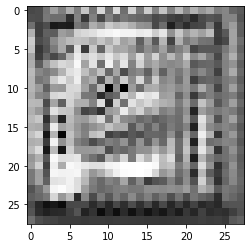

In [173]:
plt.imshow(fakeimgs[2,0], cmap="gray")

## Wasserstein GAN

The Wasserstein GAN (WGAN) ([2](https://arxiv.org/pdf/1701.07875.pdf)) replaces the discriminator with a **critic**, which is still an ANN, but with a different loss function: while the discriminator minimizes the binary cross-entropy loss, the critic minimizes an approximation of the **Wasserstein Distance** (also called Earth Mover's Distance, EMD) between the real distribution of data ($P_r$) and the *guide* distribution ($P_\theta$), which is the distribution being learned by our generator.

![](img/emd.jpg)

$EMD(P_r, P_\theta) = \inf_{\gamma\in\Pi(P_r,P_\theta)} \text{E}_{(x,y)\sim\gamma}(\vert\vert x-y \vert\vert)$

Here, $\Pi(P_r,P_\theta)$ represent the family of all possible joint distribution of $X, Y$ whose marginal $P(X)=P_r$ and $P(Y)=P_\theta$, and $\gamma$ is hence a sample from this family.

More specifically, we wish to find the *minimal density mass* to be transported from $P_\theta$ to $P_r$ such that $P_\theta$ *becomes* $P_r$.

It turns out that the critic can be an ANN $f_w$ trained by back-propagating the gradient according to the following loss function:

$\mathcal{L}_f = \frac{1}{b}\sum_{i=1}^{b} f_w(x^{(i)}) - \frac{1}{b}\sum_{i=1}^{b}f_w(g_\theta(z^{(i)}))$

The notation is easily inferrable from before:
* $b$ is the batch size
* $g$ is the generator parametrized by $\theta$
* $z$ is a sample from the *guide distribution* (usually, a Gaussian)

$w$ (parameters of $f$) is then updated using RMSProp (in the original paper) and clipping the resulting new parameters in the interval $[-0.01, 0.01]$.

The loss of $g$ is instead

$\mathcal{L}_g = \frac{1}{b}\sum_{i=1}^{m}f_w(g_\theta(z^{(i)}))$

In [190]:
d = Discriminator().to(device)
g = Generator(100).to(device)

In [191]:
loss_fn_critic = lambda pred_critic : pred_critic.mean()
loss_fn_gener = lambda pred_critic_generated : -pred_critic_generated.mean()

In [192]:
optim_d = torch.optim.RMSprop(d.parameters(), lr=5e-5)
optim_g = torch.optim.RMSprop(g.parameters(), lr=5e-5)

In [193]:
# defines the ratio of critic update vs generator update
n_critic_training = 5

In [194]:
for epoch in range(num_epochs):
    for i, (real_data, _) in enumerate(trainloader):
        real_data = real_data.to(device)

        # 1 >>>>>> train D
        optim_d.zero_grad()

        batch_size = real_data.shape[0]

        # --- real data part ---
        # labels are 1 (real_label) for all elements in the minibatch
        # gr_truth = torch.full([batch_size], real_label, dtype=torch.float).to(device)

        # get prediction for real data
        # noisy_real_data = real_data + torch.normal(0, sigma_noise, real_data.shape, device=device)
        pred_d_real = d(real_data).view(-1)
        err_d_real = loss_fn_critic(pred_d_real)
        err_d_real.backward()
        # this will be used only in the summary
        # mean_prediction_d_real = pred_d_real.mean().item()

        # --- fake data part ---
        # generate gaussian noise
        noise = torch.randn([batch_size, dim_latent]).to(device)
        # generate fake images
        synthetic_data = g(noise)
        # labels are 0 (fake_label) for all elements in the minibatch
        #gr_truth.fill_(fake_label)
        # get prediction for fake data
        pred_d_fake = d(synthetic_data.detach()).view(-1)
        err_d_fake = loss_fn_gener(pred_d_fake)
        # gradient clipping
        torch.nn.utils.clip_grad_value_(d.parameters(), 0.01)
        err_d_fake.backward()
        # these two serve only for summary purposes
        # mean_prediction_d_fake = pred_d_fake.mean().item()
        err_d_overall = err_d_fake + err_d_real

        optim_d.step()

        # 2 >>>>>> train G
        if (i + 1) % n_critic_training == 0:
            optim_g.zero_grad()
            # invert the fake/real label -- now they're all real!
            # gr_truth.fill_(real_label)
            # re-feed the synthetic data to the newly-trained discriminator
            # generate new noise (required by paper)
            noise = torch.randn([batch_size, dim_latent]).to(device)
            synthetic_data = g(noise)
            pred_d_g = d(synthetic_data).view(-1)
            # this time, get error on G's side
            err_g = loss_fn_gener(pred_d_g)
            err_g.backward()

        if (i + 1) % ite_print == 0 or (i + 1) == len(trainloader):
            print(f"Ep. {epoch + 1} It. {i+1}/{len(trainloader)} >>> Critic loss {err_d_overall.item():.3f} | G loss {err_g.item():.3f}")
    
    # after each epoch, do some generation...
    sample = g(fixed_noise).detach().cpu()
    fakeimgs[epoch] = tensor_to_numpy(sample)


Ep. 1 It. 25/235 >>> Critic loss -0.205 | G loss -0.661
Ep. 1 It. 50/235 >>> Critic loss -0.276 | G loss -0.741
Ep. 1 It. 75/235 >>> Critic loss -0.302 | G loss -0.782
Ep. 1 It. 100/235 >>> Critic loss -0.327 | G loss -0.809
Ep. 1 It. 125/235 >>> Critic loss -0.338 | G loss -0.830
Ep. 1 It. 150/235 >>> Critic loss -0.346 | G loss -0.847
Ep. 1 It. 175/235 >>> Critic loss -0.354 | G loss -0.861
Ep. 1 It. 200/235 >>> Critic loss -0.360 | G loss -0.874
Ep. 1 It. 225/235 >>> Critic loss -0.358 | G loss -0.884
Ep. 1 It. 235/235 >>> Critic loss -0.361 | G loss -0.888
Ep. 2 It. 25/235 >>> Critic loss -0.359 | G loss -0.897
Ep. 2 It. 50/235 >>> Critic loss -0.363 | G loss -0.904
Ep. 2 It. 75/235 >>> Critic loss -0.370 | G loss -0.911
Ep. 2 It. 100/235 >>> Critic loss -0.383 | G loss -0.917
Ep. 2 It. 125/235 >>> Critic loss -0.387 | G loss -0.923
Ep. 2 It. 150/235 >>> Critic loss -0.387 | G loss -0.928
Ep. 2 It. 175/235 >>> Critic loss -0.402 | G loss -0.933
Ep. 2 It. 200/235 >>> Critic loss -0.

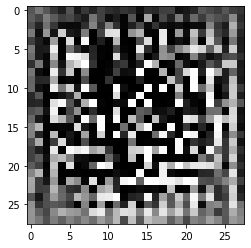

In [198]:
plt.imshow(fakeimgs[2,10], cmap="gray")

#### References

[1](https://arxiv.org/abs/1511.06434) Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks."

[2](https://arxiv.org/pdf/1701.07875.pdf) Arjovsky, Martin, et al. "Wasserstein GAN."